# PyMKS (Dask) Introduction

This notebook demonstrates homogenization and localization in PyMKS . 2-point statistics are used to predict effective properties (homogenization) and local properties are predicted using a regression technique (localization). See the [theory section](../../THEORY.html) for more details.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from pymks import (
    generate_multiphase,
    generate_delta,
    plot_microstructures,
    PrimitiveTransformer,
    FlattenTransformer,
    solve_fe,
    TwoPointCorrelation,
    FlattenTransformer,
    LocalizationRegressor
)

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Quantify Microstructures using 2-Point Statistics

The following generates two dual-phase microstructures with different morphologies. The `generate` function generates microstructures with different grains sizes and volume fractions.

In [3]:
da.random.seed(10)
np.random.seed(10)

x_data = da.concatenate([
    generate_multiphase(shape=(1, 101, 101), grain_size=(25, 25), volume_fraction=(0.5, 0.5)),
    generate_multiphase(shape=(1, 101, 101), grain_size=(95, 15), volume_fraction=(0.5, 0.5))
]).persist()

`x_data` is a Dask array. The `persist` method ensures that the data is actually calculated. The array has two chunks and two samples. The spatial shape is `(101, 101)`.

In [4]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_data

dask.array<concatenate, shape=(2, 101, 101), dtype=int64, chunksize=(1, 101, 101), chunktype=numpy.ndarray>

View the microstructures using `plot_microstructures`.

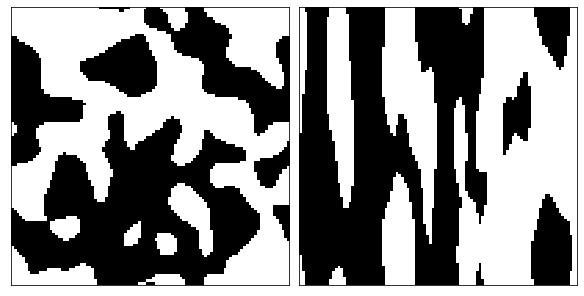

In [5]:
plot_microstructures(*x_data, cmap='gray', colorbar=False)

Compute the 2-point statistics for these two periodic microstructures using the `PrimitiveTransformer` and `TwoPointCorrelation` transformer as part of a Scikit-learn pipeline. The `PrimitiveTransformer` is a one hot encoding of the data. The `TwoPointCorrelation` computes the necessary autocorrelations and cross-correlation(s) required for subsequent machine learning.

In [6]:
correlation_pipeline = Pipeline([
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("correlations",TwoPointCorrelation())
])

x_corr = correlation_pipeline.fit(x_data).transform(x_data)

The last axis in `x_corr` accounts for the `[0, 0]` auto-correlation and the `[0, 1]` cross-correlation. By default the `[1, 0]` correlation is not calculated as it's redundant for machine learning.

In [7]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_corr

dask.array<rechunk-merge, shape=(2, 101, 101, 2), dtype=float64, chunksize=(1, 101, 101, 2), chunktype=numpy.ndarray>

The following plots the autocorrelation and cross-correlation for each microstructure. The center pixel is the volume fraction for the `[0, 0]` correlation.

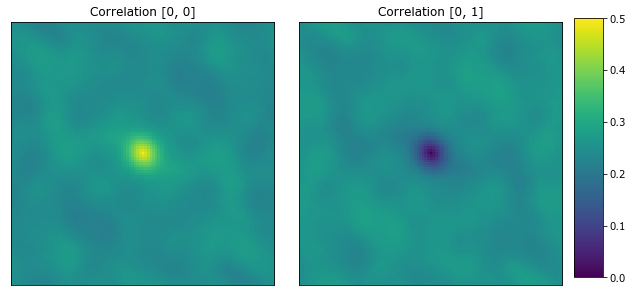

In [8]:
plot_microstructures(
    x_corr[0, :, :, 0],
    x_corr[0, :, :, 1],
    titles=['Correlation [0, 0]', 'Correlation [0, 1]']
)

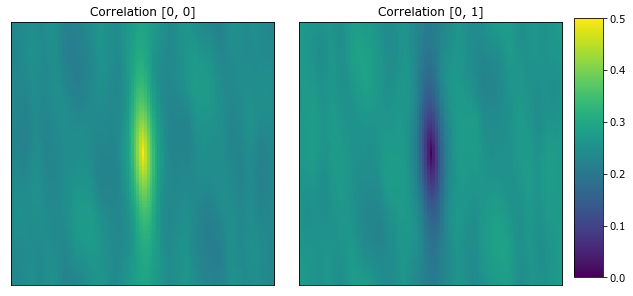

In [9]:
plot_microstructures(
    x_corr[1, :, :, 0],
    x_corr[1, :, :, 1],
    titles=['Correlation [0, 0]', 'Correlation [0, 1]']
)

2-Point statistics are a proven way to compare microstructures, and an effective descriptor for machine learning models.

## Predict Homogenized Properties

This section predicts the effective stiffness for two-phase microstructures using an homogenization pipeline.

### Data Generation

The following code generates three different types of microstructures each with 200 samples with spatial dimensions of 21 x 21.

In [10]:
def generate_data(n_samples, chunks):
    tmp = [
        generate_multiphase(shape=(n_samples, 21, 21), grain_size=x, volume_fraction=(0.5, 0.5), chunks=chunks, percent_variance=0.15)
        for x in [(20, 2), (2, 20), (8, 8)]
    ]

    x_data = da.concatenate(tmp).persist()

    y_stress = solve_fe(x_data,
                         elastic_modulus=(100, 150),
                         poissons_ratio=(0.3, 0.3),
                         macro_strain=0.001)['stress'][..., 0]

    y_data = da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1).persist()

    return x_data, y_data

In [11]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

np.random.seed(100000)
da.random.seed(100000)

x_train, y_train = generate_data(300, 50)

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

In [12]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_train

dask.array<concatenate, shape=(900, 21, 21), dtype=int64, chunksize=(50, 21, 21), chunktype=numpy.ndarray>

In [13]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

y_train

dask.array<mean_agg-aggregate, shape=(900,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>

The `x_train` contains the microstructures and `y_train` is the effective stress generated from a finite element calculation. 

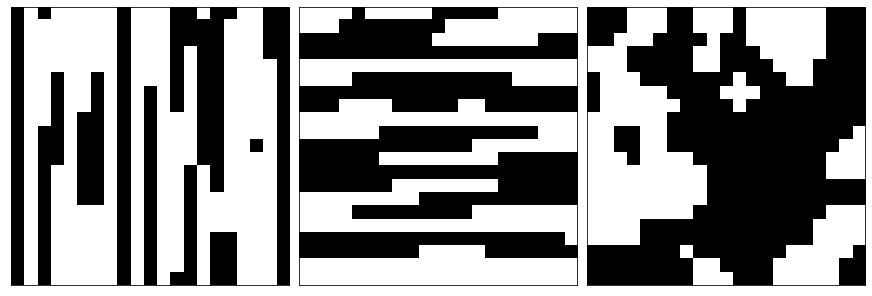

In [14]:
plot_microstructures(*x_train[::300], cmap='gray', colorbar=False)

### Low Dimensional Representation

Construct a pipeline to transform the data to a low dimensional representation. This includes the 2-point stats and a PCA. The `FlattenTransformer` is a transformer used by PyMKS to change the shape of the data for the PCA.

#### Note (issue or bug)

There are currently two issues with the pipeline.

 - The `svd_solver='full'` argument is required in the pipeline as the results are not correct without it. This might be an issue with Dask's PCA algorithms and needs further investigation.
 
 - Dask's `LinearRegression` module does not seem to solve this problem correctly and gives very different results to Sklearn's. Needs further investigation

In [15]:
pca_steps = [
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("correlations",TwoPointCorrelation(correlations=[(0, 0), (1, 1)])),
    ("flatten", FlattenTransformer()),  
    ("pca", PCA(n_components=3, svd_solver='full')),
]

pca_pipeline = Pipeline(pca_steps)

In [16]:
x_pca = pca_pipeline.fit(x_train).transform(x_train);

Dask uses lazy evaluations so the transformed data has not been calculated yet. Plotting the data or calling the `.compute()` method on the array will trigger the calculation.

In [17]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_pca

dask.array<tensordot, shape=(900, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>

The low dimensional representation of the data shows a separation based on the type of microstructure.

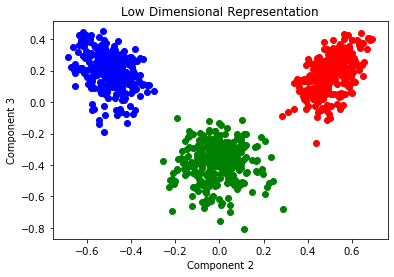

In [18]:
plt.title('Low Dimensional Representation')

plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.plot(x_pca[:300, 1], x_pca[:300, 2], 'o', color='r')
plt.plot(x_pca[300:600, 1], x_pca[300:600, 2], 'o', color='b')
plt.plot(x_pca[600:, 1], x_pca[600:, 2], 'o', color='g');

### Visualize the Task Graph

The pipeline results in an entirely lazy calulation. The task graph can be viewed to check that it remains parallel and doesn't gather all the data. The calculation has not been evaluated yet, since the graph is generated with only a small part of the data

In [19]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_pca.visualize()

### Fit and Predict

Generate test data and try and predict the effective stress using the training data. The `LinearRegression` is appended to the `pca_steps` to enable the pipeline to predict the effective stress.

In [20]:
pipeline = Pipeline(pca_steps + [("regressor", LinearRegression())])

#### Note (issue or bug)

The `fit` method currently does not take a Dask array. This needs to be resolved.

In [21]:
pipeline.fit(x_train, np.array(y_train));

Generate some test data to test the fit.

In [22]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_test, y_test = generate_data(10, 10)

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Both the test data and fit data will be used to check the goodness of fit

In [23]:
y_predict = pipeline.predict(x_test)

In [24]:
y_train_predict = pipeline.predict(x_train)

### Parity Plot

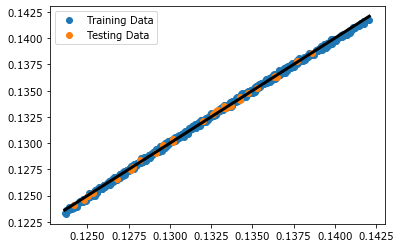

In [25]:
plt.plot(y_train, y_train_predict, 'o', label='Training Data')
plt.plot(y_test, y_predict, 'o', label='Testing Data')
plt.plot([np.min(y_train), np.max(y_train)], [np.min(y_train), np.max(y_train)], color='k', lw=3)
plt.legend();

## Predict Local Properties

This section predicts local properties using the `LocalizationRegressor`. The model can be trained using only a delta microstructure. 

### Generate the Data

#### Delta Data

Generate the delta data to fit the model.

In [26]:
x_delta = generate_delta(n_phases=2, shape=(21, 21)).persist()

In [27]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_delta

dask.array<array, shape=(2, 21, 21), dtype=int64, chunksize=(2, 21, 21), chunktype=numpy.ndarray>

The `y_delta` data is also required to fit the model and is generated using a FE simulation.

In [28]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

y_delta = solve_fe(x_delta,
                   elastic_modulus=(100, 150),
                   poissons_ratio=(0.3, 0.3),
                   macro_strain=0.001)['strain'][..., 0].persist()

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

In [29]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

y_delta

dask.array<getitem, shape=(2, 21, 21), dtype=float64, chunksize=(2, 21, 21), chunktype=numpy.ndarray>

#### Test Data

Generate the test data to test the model.

In [30]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

da.random.seed(2341234)

x_test = da.random.randint(2, size=(1,) + x_delta.shape[1:]).persist()
y_test = solve_fe(x_test,
                  elastic_modulus=(100, 150),
                  poissons_ratio=(0.3, 0.3),
                  macro_strain=0.001)['strain'][..., 0].persist()

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to u.

### Fit the Model

Generate the pipeline and fit the delta microstructure and predicted strain field.

In [31]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])

In [32]:
model.fit(x_delta, y_delta);

The model is calibrated so can now be used to predict the test data

In [33]:
y_predict = model.predict(x_test)

Plot the test data.

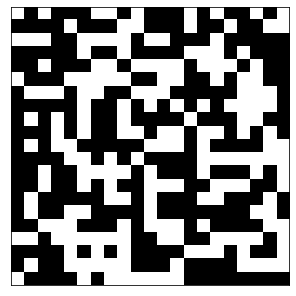

In [34]:
plot_microstructures(x_test[0], cmap='gray', colorbar=False)

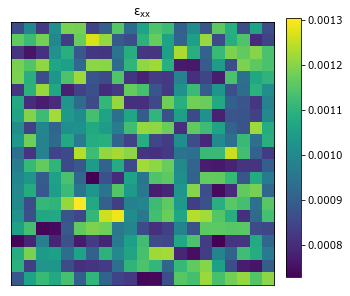

In [35]:
plot_microstructures(y_test[0], titles='$\epsilon_{xx}$')

Compare the predicted and test results

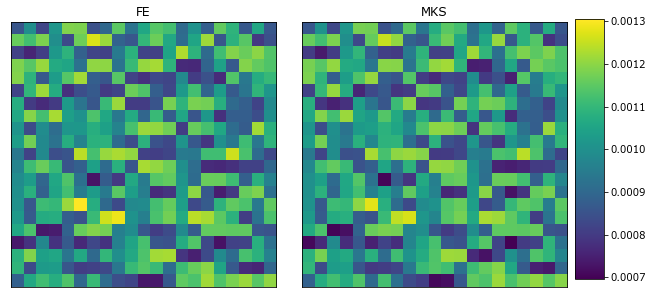

In [36]:
plot_microstructures(y_test[0], y_predict[0], titles=['FE', 'MKS'])

The `LocalizationRegressor` works well when the mapping is mostly linear (e.g. linear elasticity) where the contrast in materials properties is not too large.